<img src="../img/banner.png" alt="Powered by MSD-LIVE" width = 600 style="display: block;margin-left: auto;margin-right: auto;width: 50%;" />


# CSDMS 2021 Annual Meeting

### CLINIC:  Thursday, May 20 11:00am - 1pm MST

## GCAM and Demeter:  A global, integrated human-Earth systems perspective to modeling land projections

### Pralit Patel, pralit.patel<span></span>@pnnl.gov and Chris Vernon, chris.vernon<span></span>@pnnl.gov

Researchers and decision makers are increasingly interested in understanding the many ways in which human and Earth systems interact with one another, at scales from local (e.g., a city) to regional to global. For example, how might changes in population, income, or technology development alter crop production, energy demand, or water withdrawals? How do changes in one region's demand for energy affect energy, water, and land in other regions? This session will focus on two models – GCAM and Demeter – that provide capabilities to address these types of questions.


GCAM is an open-source, global, market equilibrium model that represents the linkages between energy, water, land, climate, and economic systems. A strength of GCAM is that it can be used to quickly explore, and quantify the uncertainty in, a large number of alternate future scenarios while accounting for multi-sector, human-Earth system dynamics. One of GCAM’s many outputs is projected land cover/use by subregion. Subregional projections provide context and can be used to understand regional land dynamics; however, Earth System Models (ESMs) generally require gridded representations of land at finer scales. Demeter, a land use and land cover disaggregation model, was created to provide this service. Demeter directly ingests land projections from GCAM and creates gridded products that match the desired resolution and land class requirements of the user.

This clinic will introduce both GCAM and Demeter at a high-level. We will also provide a hands-on walk through for a reference case so attendees can become familiar with configuring and running these two models. Our goal will be for attendees to leave the clinic with an understanding of 1) the value of capturing a global perspective when informing subregional and local analysis, 2) possibilities to conduct scenario exploration experiments that capture multi-sector/scale dynamics, 3) and a hands-on experience with GCAM and Demeter.

## Software Availability

Demeter: https://github.com/JGCRI/demeter  
GCAM: https://github.com/JGCRI/gcam-core  
gcamwrapper: https://github.com/JGCRI/gcamwrapper  
im3vis: https://github.com/IMMM-SFA/im3vis


# Value of this demonstration

Demonstrate how to integrate GCAM - using its new Python wrapper - into existing workflows that research energy, water, land, climate, and socioeconomic dynamics to provide a global, human-Earth perspective.

## Overview of the experiment to demonstrate capabilities

For this demonstration we will attempt to incorporate climate changed induced yield impacts in GCAM.  To do so we will utilize an archive of global gridded crop model results published as part of the [ISI-MIP](https://doi.org/10.1073/pnas.1222463110) project.  While this exercise has been conducted before: [Snyder 2020](https://doi.org/10.1371/journal.pone.0237918), [Calvin 2020](https://doi.org/10.1142/S2010007820500050).  A short coming in the design of these experiments is that they assume a fixed map of crop production which is used to weight the gridded yield impacts.  Similar studies such as [Fujimori 2018](https://doi.org/10.3390/su10103673) have indicated missing this dynamic can create significant bias.

We can use the dynamic GCAM - Demeter coupling to address this short coming by updating the map of where GCAM+Demeter is projecting the crops are now grown.  Which we attempt to do in this demonstration.  With the caveat that quite a number of simplifying assumptions were made to ensure computational tractability.

### Outline

- Load and initialize GCAM through its calibration years
  - Visualizations of GCAM land use results
- Load Demeter and downscale GCAM land use decisions
- Run and query the first projected GCAM results _without_ climate impacts
  - Query results for comparison
- Load ISIMIP yields and weight by Demeter crop maps
- Apply yield impacts and re-run GCAM
- Compare results with and without climate impacts

# Import packages

In [1]:
# general purpose package
import time
import pkg_resources

import pandas as pd
import geopandas as gpd

# load demeter and GCAM via gcamwrapper
import demeter
from demeter import Model
import gcamwrapper as gw

# some utilities to help keep the notebook tidy
import im3vis
import demo_utils


# Using GCAM via `gcamwrapper`

#### Load GCAM specific files

In [2]:
# path to the exe directory where gcam-core is installed
core_exe_path = 'gcam-core/exe'

# path to the xml configuration file you want to use
config_xml_file = 'configuration_reduced.xml'


#### Instantiate GCAM

In [3]:
%%time

g = gw.Gcam(config_xml_file, core_exe_path)


Running GCAM model code base version 5.3 revision gcam-v5.3

Configuration file:  configuration_reduced.xml
Parsing input files...
Parsing ../input/gcamdata/xml/no_climate_model.xml scenario component.
Parsing ../input/gcamdata/xml/socioeconomics_gSSP2.xml scenario component.
Parsing ../input/gcamdata/xml/resources.xml scenario component.
Parsing ../input/gcamdata/xml/en_supply.xml scenario component.
Parsing ../input/gcamdata/xml/en_transformation.xml scenario component.
Parsing ../input/gcamdata/xml/electricity.xml scenario component.
Parsing ../input/gcamdata/xml/heat.xml scenario component.
Parsing ../input/gcamdata/xml/hydrogen.xml scenario component.
Parsing ../input/gcamdata/xml/en_distribution.xml scenario component.
Parsing ../input/gcamdata/xml/industry.xml scenario component.
Parsing ../input/gcamdata/xml/industry_incelas_gssp2.xml scenario component.
Parsing ../input/gcamdata/xml/cement.xml scenario component.
Parsing ../input/gcamdata/xml/cement_incelas_gssp2.xml scenario 

#### Run the model through its calibration years through the base year of 2015

In [4]:
%%time

final_cal_period = g.convert_year_to_period(2015)
g.run_to_period(final_cal_period)


Starting a model run. Running period 4
Model run beginning.
Period 0: 1975
Model solved with last period's prices.

Period 1: 1990
Model solved normally. Iterations period 1: 1. Total iterations: 2

Period 2: 2005
Model solved normally. Iterations period 2: 1. Total iterations: 3

Period 3: 2010
Model solved normally. Iterations period 3: 1. Total iterations: 4

Period 4: 2015
Model solved normally. Iterations period 4: 1. Total iterations: 5

All model periods solved correctly.
Model run completed.
CPU times: user 32.5 s, sys: 558 ms, total: 33 s
Wall time: 33 s


#### Query land allocation data from the current GCAM run to produce projected land allocation by land region

In [5]:
# load query from query library
query_string = gw.get_query('land', 'land_allocation')

# query specific information
query_params = {'region': ['*'], 'leaf': ['*'], 'year': ['<=', g.get_current_year()]}

# create an output data frame containing land data
land_df = g.get_data(query_string, query_params)

land_df.head()


,region,child-nodes,year,land-allocation
0,Africa_Eastern,Corn_AfrCstE_IRR_hi,1975,0.009381
1,Africa_Eastern,Corn_AfrCstE_IRR_hi,1990,0.008705
2,Africa_Eastern,Corn_AfrCstE_IRR_hi,2005,0.010365
3,Africa_Eastern,Corn_AfrCstE_IRR_hi,2010,0.012348
4,Africa_Eastern,Corn_AfrCstE_IRR_hi,2015,0.013194


## Explore GCAM land allocation outputs for year 2015

#### Load into a demeter formatted dataframe

In [6]:
gcam_df = demeter.format_gcam_data(df=land_df, start_year=2015, through_year=2015)

gcam_df.head()


,region,glu_name,region_id,metric_id,landclass,2015
0,Africa_Eastern,AfrCstE,2,171.0,Corn_IRR,0.026389
1,Africa_Eastern,AfrCstE,2,171.0,Corn_RFD,8.827320
2,Africa_Eastern,AfrCstE,2,171.0,FiberCrop_IRR,0.021205
3,Africa_Eastern,AfrCstE,2,171.0,FiberCrop_RFD,0.189931
4,Africa_Eastern,AfrCstE,2,171.0,Forest,4.855879


#### GCAM total land allocation by region for all land classes

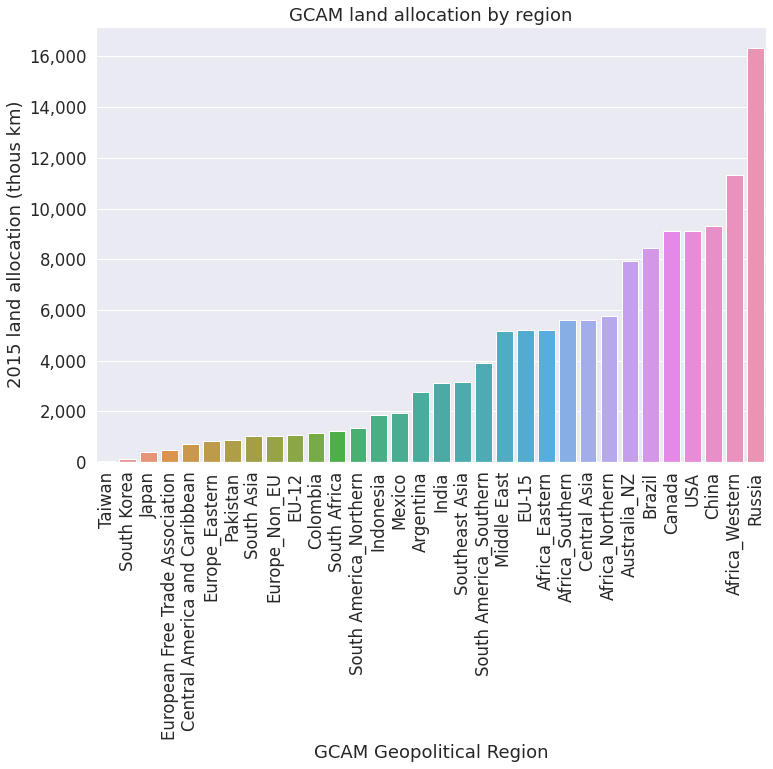

In [7]:
reg_ax = im3vis.gcam_demeter_region(gcam_df, target_year='2015')


#### GCAM total land allocation by region for combined Corn

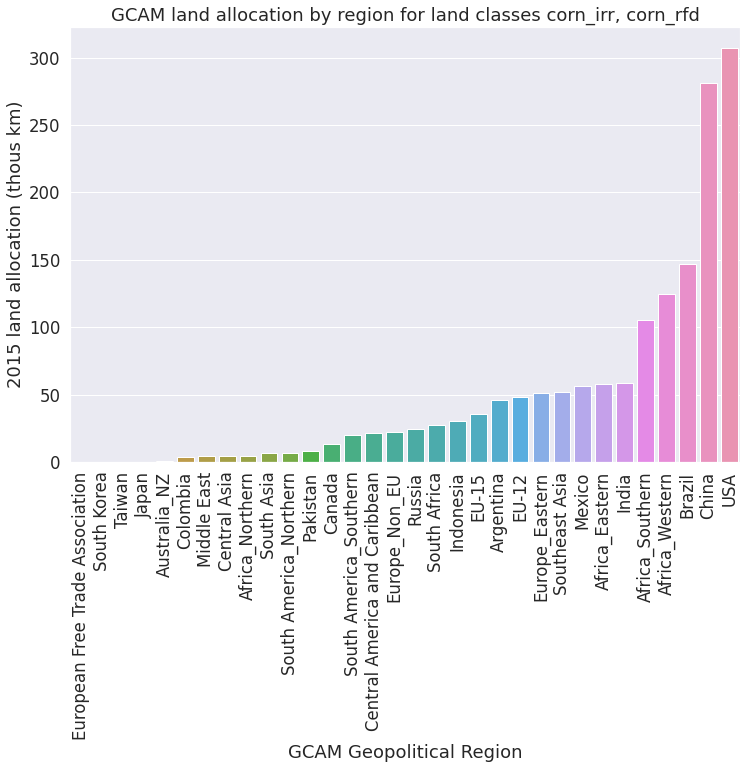

In [8]:
reg_ax = im3vis.gcam_demeter_region(gcam_df, 
                                    target_year='2015', 
                                    landclass_list=['corn_irr', 'corn_rfd'])


#### GCAM `corn` allocation for year 2015 for the CONUS

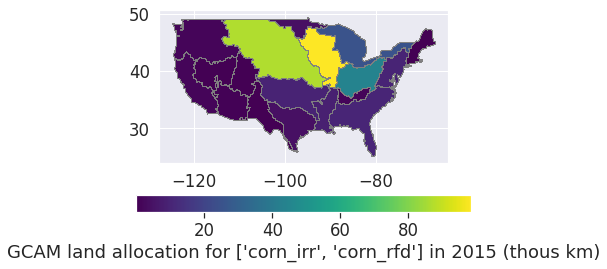

In [9]:
agg_df = im3vis.plot_gcam_basin(gcam_df,
                                target_year='2015',
                                landclass_list=['corn_irr', 'corn_rfd'],
                                setting='crop_yield',
                                scope='conus')


#### GCAM `corn` allocation for year 2015 for global basins

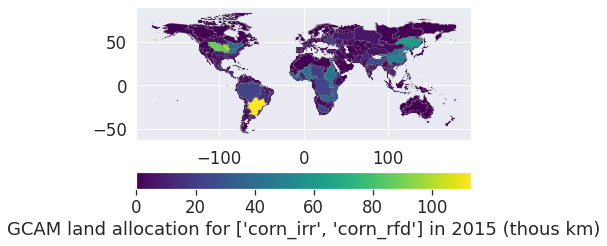

In [10]:
agg_df = im3vis.plot_gcam_basin(gcam_df,
                                target_year='2015',
                                landclass_list=['corn_irr', 'corn_rfd'],
                                setting='crop_yield',
                                scope='global')


## Run Demeter

#### Instantiate Demeter

In [ ]:
model.clean

In [28]:
import os

config_file_dir =  os.path.abspath(os.path.join(os.getcwd(), "../.."))
config_file = os.path.join(config_file_dir, 'csdms_clinic_config.ini')

print(os.getcwd())

print(config_file)

/home/msdadmin/csdms_demo/gcam-core/exe
/home/msdadmin/csdms_demo/csdms_clinic_config.ini


In [19]:
# path to Demeter configuration file on the server
config_file = '../../csdms_clinic_config.ini'

# instantiate demeter model
model = Model(config_file=config_file, 
              gcamwrapper_df=land_df,
              write_outputs=False,
              write_logfile=False)


ERROR:root:File not found:  ../../csdms_clinic_config.ini
ERROR:root:Confirm path and retry.


OSError: File not found: ../../csdms_clinic_config.ini. Confirm path and retry.

#### Load model data and prepare run

In [ ]:
model.initialize()


#### Process the target time step from the GCAM output DataFrame for land allocation

In [ ]:
%%time

# process first year
demeter_2015 = model.process_step()


## Explore Demeter's outputs

#### Build a geodataframe from the outputs

In [ ]:
# a geopandas data frame of demeter's output land allocation data with geometry
demeter_gdf = im3vis.build_geodataframe(demeter_2015)


#### Plot Demeter `corn` output for year 2015 for the CONUS

In [ ]:
r = im3vis.plot_demeter_raster(demeter_gdf=demeter_gdf, 
                               landclass_list=['crop2_irr', 'crop2_rfd'],
                               target_year='2015', 
                               scope='conus',
                               resolution='0.5')


#### Plot Demeter `forest` global output for 2015

In [ ]:
r = im3vis.plot_demeter_raster(demeter_gdf=demeter_gdf, 
                               landclass_list=['unmanagedforest', 'forest'],
                               target_year='2015', 
                               scope='global',
                               resolution='0.5')


#### Clean up the logger

In [ ]:
model.cleanup()


## Run the next model period (2020) in GCAM _without_ yield impacts

In [ ]:
%%time

g.run_to_period()


## Query and visualize model results _without_ accounting for yield impact for comparison purposes

In [ ]:
# load query for land allocation
query_string = gw.get_query('land', 'land_allocation')
query_params = {'region': ['*'], 'leaf': ['*'], 'year': ['<=', g.get_current_year()]}

# run the query
land_df = g.get_data(query_string, query_params)

# get Corn producer prices
query_string = gw.get_query('ag', 'prices')
query_params = {'region': ['*'], 
                'sector': ['=', 'Corn'], 
                'year': ['=', g.get_current_year()]}

prod_prices = g.get_data(query_string, query_params)

# get domestic Corn prices (accounting for trade)
query_params['sector'] = ["=", 'regional corn']

dom_prices = g.get_data(query_string, query_params)

# get crop production data
query_string = gw.get_query('ag', 'production')
query_params = {'region': ['*'],
                'sector': ['*'],
                'year': ['=', g.get_current_year()]}
production = g.get_data(query_string, query_params)

# finally get the actual yields
query_string = gw.get_query('ag', 'yield')
query_params = {'region': ['*'], 
                'sector': ['=', 'Corn'], 
                'tech': ['*'], 
                'year': ['=', g.get_current_year()]}

yields = g.get_data(query_string, query_params)


## Generate yield impacts from ISIMIP PDSST data using downscaled land from Demeter to weight and map them to GCAM land regions

In [ ]:
yield_scaler_df = demo_utils.get_yield_scalers(demeter_2015, g.get_current_year())
yield_scaler_df.head()


In [ ]:
yields_new = yields.merge(yield_scaler_df, on=["region", "sector", "technology", "year"], how="inner")
yields_new['yield'] *= yields_new['yield_scaler']
yields_new = yields_new.filter(["region", "sector", "technology", "year", "yield"])

yields_new.head()


## Update yields in GCAM for year 2020 and re-run

In [ ]:
# get the same query string
query_string = gw.get_query('ag', 'yield')

# however the syntax for the query params are slightly different for set data as we
# need to explicitly tell it which match with the '+' argument and of course we do
# not give the values to compare against as those are coming from the DataFrame
query_params = {'region': ['+', '='], 
                'sector': ['+', '='], 
                'tech': ['+', '='], 
                'year': ['+', '=']}

g.set_data(yields_new, query_string, query_params)

# re-run 2020
g.run_to_period(g.get_current_period())


## Get the results _with_ impacts for comparison

In [ ]:
# load query for land allocation
query_string = gw.get_query('land', 'land_allocation')
query_params = {'region': ['*'], 
                'leaf': ['*'], 
                'year': ['<=', g.get_current_year()]}

# run the query
land_df_new = g.get_data(query_string, query_params)

# get Corn producer prices
query_string = gw.get_query('ag', 'prices')
query_params = {'region': ['*'], 
                'sector': ['=', 'Corn'], 
                'year': ['=', g.get_current_year()]}

prod_prices_new = g.get_data(query_string, query_params)

# get domestic Corn prices (accounting for trade)
query_params['sector'] = ["=", 'regional corn']

dom_prices_new = g.get_data(query_string, query_params)

# get crop production data
query_string = gw.get_query('ag', 'production')
query_params = {'region': ['*'],
                'sector': ['*'],
                'year': ['=', g.get_current_year()]}
production_new = g.get_data(query_string, query_params)

# finally get the actual yields
query_string = gw.get_query('ag', 'yield')
query_params = {'region': ['*'], 
                'sector': ['=', 'Corn'], 
                'tech': ['*'], 
                'year': ['=', g.get_current_year()]}

yields_new = g.get_data(query_string, query_params)


## Visualizations comparing 2020 with and without crop yield updates

In [ ]:
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
def bar_diff(data, metric_id, figure_size=(12, 8), font_scale=1.5):
    sns.set(font_scale=font_scale)
    fig, ax = plt.subplots(figsize=figure_size)
    p = sns.barplot(x="region", y=metric_id, data=data,
            label="1975$/kg")
    p.set_xticklabels(p.get_xticklabels(), rotation=90)
    return p


In [ ]:
prod_prices_diff = demo_utils.calc_diff(prod_prices_new, prod_prices)
prod_price_comp = bar_diff(prod_prices_diff, "diff_rel")

In [ ]:
dom_prices_diff = demo_utils.calc_diff(dom_prices_new, dom_prices)
dom_price_comp = bar_diff(dom_prices_diff, "diff_rel")

In [ ]:
gcam_df.head()

In [ ]:
#yield_formater = demeter.FormatGcamDataFrame(yields, start_year=2015, through_year=2015)
#yield_formater.GCAM_LANDALLOC_FIELD = 'yield'
#yield_formater.GCAM_NODES_FIELD = 'technology'
#yields_plotdf = yield_formater.format_land_data()
yields_plotdf = demeter.format_gcam_data(df=yields, start_year=2015, through_year=2015, gcam_landalloc_field="yield", gcam_nodes_field="technology")
yields_plotdf.head()

In [ ]:
corn_prod = production.query('sector == "Corn"')
#prod_formater = demeter.FormatGcamDataFrame(corn_prod, start_year=2015, through_year=2015)
#prod_formater.GCAM_LANDALLOC_FIELD = 'physical-output'
#prod_formater.GCAM_NODES_FIELD = 'technology'
#prod_plotdf = prod_formater.format_land_data()
prod_plotdf = demeter.format_gcam_data(df=corn_prod, start_year=2015, through_year=2015, gcam_landalloc_field="physical-output", gcam_nodes_field="technology")
prod_plotdf.head()

In [ ]:
production.head()

In [ ]:
agg_df = im3vis.plot_gcam_basin(prod_plotdf,
                                target_year='2015',
                                landclass_list=['corn_irr', 'corn_rfd'],
                                setting='crop_yield',
                                scope='global')

In [ ]:
yields_plotdf_sub = yields_plotdf.query('landclass == "Corn_RFD"')
agg_df = im3vis.plot_gcam_basin(yields_plotdf_sub.copy(),
                                target_year='2015',
                                landclass_list=['corn_rfd'],
                                setting='crop_yield',
                                scope='global')